In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (31/31), done.


/tmp/ipykernel_11828/707780074.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


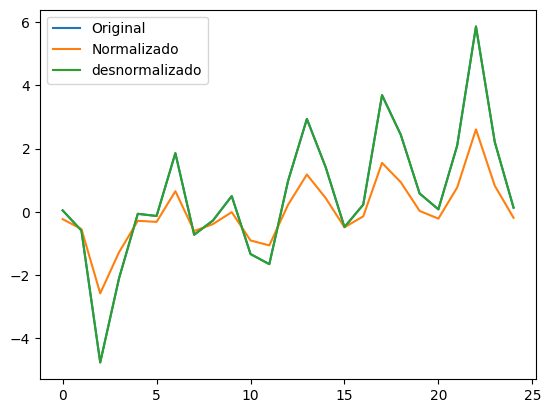

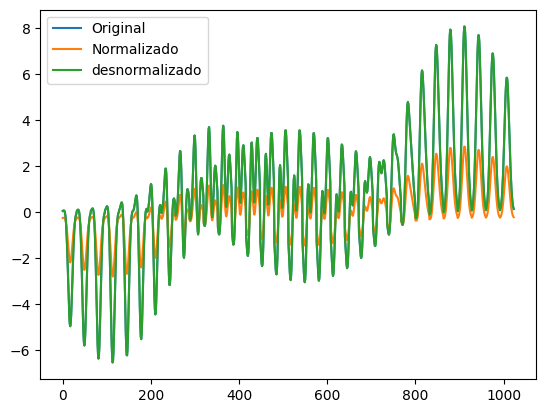

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [3]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-24 00:44:26.520124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 00:44:26.520185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 00:44:26.521770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 00:44:26.547342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-10-24 00:44:27.984891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [8]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.1,
            hidden_sizes = [ [17], [18], [19], [20], [21], [22]],
            regularizers=[0.01, 0.04],
            learning_rate=[0.07, 0.06])

Testando combinacao1: Hidden Size=[17], regularizer=0.01, learning_rate=0.07
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_5,0.986875,0.733039,0.963368,0.597891,0.874118,0.087766,1.785167,0.092313,0.383701,0.238007,0.723025,0.296252,1.007000,0.308865,142.866173,226.968605
model_1_5_6,0.986990,0.733033,0.962206,0.595737,0.872800,0.086997,1.785212,0.095240,0.385757,0.240498,0.727104,0.294953,1.006939,0.307510,142.883755,226.986187
model_1_5_4,0.986730,0.733026,0.964580,0.600179,0.875503,0.088737,1.785259,0.089259,0.381518,0.235388,0.718868,0.297888,1.007077,0.310569,142.844156,226.946588
model_1_5_7,0.987079,0.733010,0.961097,0.593704,0.871548,0.086401,1.785366,0.098036,0.387696,0.242866,0.731080,0.293940,1.006891,0.306454,142.897517,226.999949
model_1_5_3,0.986549,0.732987,0.965841,0.602603,0.876955,0.089950,1.785517,0.086080,0.379205,0.232643,0.714651,0.299916,1.007174,0.312684,142.817010,226.919442
model_1_5_8,0.987147,0.732973,0.960038,0.591791,0.870359,0.085948,1.785609,0.100703,0.389522,0.245113,0.734948,0.293169,1.006855,0.305649,142.908029,227.010461
model_1_5_9,0.987197,0.732927,0.959032,0.589987,0.869233,0.085615,1.785922,0.103240,0.391244,0.247242,0.738696,0.292601,1.006828,0.305058,142.915780,227.018211
model_1_5_2,0.986325,0.732918,0.967149,0.605173,0.878475,0.091447,1.785976,0.082785,0.376753,0.229769,0.710394,0.302403,1.007294,0.315276,142.783984,226.886416
model_1_5_10,0.987232,0.732872,0.958076,0.588289,0.868168,0.085383,1.786287,0.105648,0.392864,0.249256,0.742320,0.292204,1.006810,0.304643,142.921217,227.023649
model_1_5_1,0.986050,0.732813,0.968499,0.607897,0.880062,0.093281,1.786678,0.079382,0.374153,0.226768,0.706124,0.305419,1.007440,0.318421,142.744283,226.846715


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_17,0.994309,0.742553,0.883874,0.966458,0.923047,0.038058,1.721547,0.160144,0.041741,0.100942,0.312583,0.195084,1.003035,0.203389,144.537303,228.639735
model_1_6_18,0.994207,0.742550,0.878475,0.965125,0.919577,0.038736,1.721572,0.167588,0.043399,0.105494,0.300623,0.196815,1.003089,0.205194,144.501965,228.604397
model_1_6_16,0.994401,0.742541,0.889499,0.967853,0.926665,0.037438,1.721626,0.152387,0.040005,0.096196,0.325444,0.193490,1.002986,0.201727,144.570114,228.672546
model_1_6_19,0.994100,0.742533,0.873311,0.963854,0.916260,0.039456,1.721681,0.174710,0.044980,0.109845,0.289511,0.198635,1.003147,0.207091,144.465150,228.567582
model_1_6_15,0.994482,0.742510,0.895340,0.969308,0.930426,0.036900,1.721835,0.144331,0.038194,0.091262,0.339290,0.192094,1.002943,0.200272,144.599084,228.701516
model_1_6_20,0.993988,0.742507,0.868385,0.962645,0.913097,0.040202,1.721856,0.181503,0.046485,0.113994,0.279176,0.200504,1.003206,0.209039,144.427694,228.530126
model_1_6_21,0.993874,0.742473,0.863695,0.961497,0.910087,0.040962,1.722084,0.187971,0.047914,0.117942,0.269572,0.202390,1.003267,0.211006,144.390232,228.492664
model_1_6_14,0.994546,0.742455,0.901383,0.970823,0.934321,0.036468,1.722202,0.135998,0.036309,0.086153,0.354185,0.190966,1.002909,0.199096,144.622638,228.725070
model_1_6_22,0.993760,0.742433,0.859241,0.960409,0.907229,0.041726,1.722351,0.194114,0.049268,0.121691,0.260645,0.204270,1.003328,0.212966,144.353256,228.455688
model_1_6_23,0.993646,0.742389,0.855018,0.959379,0.904521,0.042487,1.722647,0.199937,0.050550,0.125243,0.252345,0.206123,1.003389,0.214898,144.317132,228.419564


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_5,0.992751,0.742845,0.989273,0.990157,0.989434,0.048472,1.719596,0.241759,0.036209,0.138984,0.208305,0.220164,1.003866,0.229537,144.053535,228.155967
model_1_7_6,0.992593,0.742842,0.988904,0.989700,0.989054,0.049528,1.719617,0.250063,0.037887,0.143975,0.204047,0.222550,1.003950,0.232024,144.010416,228.112847
model_1_7_4,0.992906,0.742831,0.989665,0.990578,0.989829,0.047435,1.719690,0.232920,0.034659,0.133790,0.212940,0.217797,1.003783,0.227069,144.096769,228.199201
model_1_7_7,0.992434,0.742825,0.988559,0.989218,0.988691,0.050591,1.719729,0.257851,0.039660,0.148756,0.200128,0.224924,1.004035,0.234500,143.967970,228.070402
model_1_7_8,0.992276,0.742797,0.988235,0.988718,0.988344,0.051649,1.719914,0.265149,0.041500,0.153325,0.196524,0.227263,1.004119,0.236938,143.926582,228.029014
model_1_7_3,0.993056,0.742796,0.990082,0.990954,0.990239,0.046434,1.719924,0.223523,0.033275,0.128399,0.217979,0.215485,1.003703,0.224659,144.139453,228.241885
model_1_7_9,0.992120,0.742761,0.987932,0.988206,0.988012,0.052693,1.720157,0.271980,0.043382,0.157681,0.193202,0.229550,1.004203,0.239322,143.886540,227.988972
model_1_7_2,0.993198,0.742736,0.990524,0.991274,0.990662,0.045488,1.720328,0.213555,0.032098,0.122826,0.223472,0.213278,1.003628,0.222358,144.180634,228.283066
model_1_7_10,0.991967,0.742718,0.987648,0.987689,0.987697,0.053718,1.720444,0.278369,0.045285,0.161827,0.190140,0.231771,1.004284,0.241638,143.848028,227.950460
model_1_7_11,0.991818,0.742671,0.987383,0.987171,0.987398,0.054716,1.720763,0.284338,0.047189,0.165764,0.187317,0.233915,1.004364,0.243873,143.811197,227.913628


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.991326,0.741697,0.960935,0.988869,0.974117,0.058005,1.727270,0.060830,0.009146,0.034988,0.185939,0.240843,1.004626,0.251096,143.694442,227.796874
model_1_8_1,0.992067,0.741275,0.960615,0.979104,0.970965,0.053051,1.730094,0.061328,0.017170,0.039249,0.205069,0.230328,1.004231,0.240133,143.873012,227.975443
model_1_8_2,0.992617,0.740762,0.960137,0.966448,0.966842,0.049368,1.733529,0.062073,0.027570,0.044821,0.222760,0.222189,1.003937,0.231649,144.016900,228.119331
model_1_8_3,0.993011,0.740180,0.959533,0.951655,0.961999,0.046735,1.737415,0.063013,0.039725,0.051369,0.239119,0.216183,1.003727,0.225386,144.126519,228.228951
model_1_8_4,0.993276,0.739551,0.958833,0.935340,0.956637,0.044964,1.741622,0.064103,0.053131,0.058617,0.254238,0.212047,1.003586,0.221075,144.203781,228.306213
model_1_8_5,0.993435,0.738891,0.958061,0.918008,0.950924,0.043897,1.746040,0.065305,0.067373,0.066339,0.268222,0.209516,1.003501,0.218435,144.251825,228.354256
model_1_8_6,0.993510,0.738211,0.957238,0.900063,0.944996,0.043400,1.750583,0.066587,0.082118,0.074352,0.281153,0.208328,1.003461,0.217197,144.274572,228.377004
model_1_8_7,0.993515,0.737524,0.956380,0.881831,0.938961,0.043364,1.755179,0.067923,0.097100,0.082511,0.293107,0.208239,1.003459,0.217105,144.276268,228.378700
model_1_8_8,0.993466,0.736837,0.955502,0.863571,0.932905,0.043693,1.759771,0.069290,0.112104,0.090697,0.304168,0.209028,1.003485,0.217927,144.261148,228.363580
model_1_8_9,0.993374,0.736158,0.954616,0.845488,0.926898,0.044310,1.764313,0.070670,0.126963,0.098817,0.314399,0.210500,1.003534,0.219461,144.233086,228.335518


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.991384,0.727071,0.994985,0.999955,0.996340,0.057612,1.825077,0.050420,0.000161,0.025291,0.527561,0.240025,1.004595,0.250243,143.708051,227.810483
model_1_9_1,0.991766,0.725441,0.992430,0.999863,0.994458,0.055061,1.835978,0.076111,0.000488,0.038300,0.645670,0.234652,1.004392,0.244641,143.798613,227.901045
model_1_9_2,0.991907,0.723721,0.989457,0.999708,0.992256,0.054121,1.847481,0.105993,0.001037,0.053515,0.755465,0.232639,1.004316,0.242543,143.833073,227.935504
model_1_9_3,0.991864,0.721967,0.986234,0.999490,0.989855,0.054405,1.859205,0.138398,0.001814,0.070106,0.856676,0.233249,1.004339,0.243179,143.822592,227.925024
model_1_9_4,0.991685,0.720224,0.982891,0.999208,0.987351,0.055599,1.870866,0.172007,0.002818,0.087413,0.949435,0.235795,1.004434,0.245834,143.779166,227.881598
model_1_9_5,0.991408,0.718519,0.979527,0.998866,0.984816,0.057452,1.882264,0.205834,0.004034,0.104934,1.034111,0.239691,1.004582,0.249896,143.713612,227.816044
model_1_9_6,0.991062,0.716873,0.976210,0.998471,0.982301,0.059768,1.893270,0.239178,0.005439,0.122309,1.111229,0.244475,1.004767,0.254883,143.634570,227.737001
model_1_9_7,0.990669,0.715298,0.972989,0.998031,0.979845,0.062397,1.903801,0.271563,0.007004,0.139283,1.181398,0.249795,1.004977,0.260429,143.548466,227.650898
model_1_9_8,0.990246,0.713801,0.969894,0.997555,0.977471,0.065226,1.913814,0.302682,0.008695,0.155689,1.245223,0.255394,1.005202,0.266266,143.459795,227.562227
model_1_9_9,0.989806,0.712384,0.966942,0.997053,0.975195,0.068167,1.923289,0.332354,0.010482,0.171418,1.303304,0.261089,1.005437,0.272204,143.371575,227.474007


DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[17], regularizer=0.01, learning_rate=0.06
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [======

2024-10-24 01:01:00.716383: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_19,0.990260,0.811836,0.987002,0.946383,0.978245,0.065134,1.258254,0.071892,0.285694,0.178793,0.519973,0.255213,1.005195,0.266078,143.462623,227.565055
model_2_6_18,0.990389,0.811814,0.987215,0.948398,0.978970,0.064270,1.258402,0.070711,0.274957,0.172834,0.546443,0.253515,1.005126,0.264308,143.489322,227.591754
model_2_6_17,0.990508,0.811776,0.987436,0.950486,0.979721,0.063475,1.258658,0.069488,0.263832,0.166660,0.574590,0.251943,1.005063,0.262668,143.514217,227.616649
model_2_6_16,0.990613,0.811718,0.987664,0.952644,0.980498,0.062769,1.259041,0.068227,0.252330,0.160278,0.604526,0.250537,1.005006,0.261203,143.536587,227.639019
model_2_6_15,0.990702,0.811639,0.987899,0.954871,0.981299,0.062175,1.259573,0.066929,0.240466,0.153698,0.636360,0.249350,1.004959,0.259965,143.555595,227.658027
model_2_6_14,0.990770,0.811533,0.988140,0.957162,0.982122,0.061721,1.260279,0.065599,0.228260,0.146930,0.670208,0.248437,1.004923,0.259013,143.570269,227.672701
model_2_6_13,0.990813,0.811397,0.988385,0.959512,0.982966,0.061437,1.261188,0.064241,0.215738,0.139990,0.706199,0.247864,1.004900,0.258416,143.579500,227.681932
model_2_6_12,0.990824,0.811226,0.988634,0.961915,0.983829,0.061359,1.262330,0.062862,0.202933,0.132897,0.744463,0.247707,1.004894,0.258252,143.582035,227.684467
model_2_6_11,0.990799,0.811015,0.988886,0.964364,0.984708,0.061528,1.263743,0.061468,0.189882,0.125675,0.785152,0.248049,1.004907,0.258609,143.576515,227.678947
model_2_6_10,0.990729,0.810757,0.989139,0.966850,0.985599,0.061992,1.265466,0.060070,0.176634,0.118352,0.828409,0.248983,1.004944,0.259582,143.561489,227.663921


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_6,0.993613,0.813809,0.866669,0.994294,0.992177,0.042712,1.245063,0.043047,0.070997,0.057022,0.749096,0.206668,1.003407,0.215467,144.306561,228.408993
model_2_7_5,0.993416,0.813793,0.876935,0.994990,0.992999,0.044025,1.245166,0.039732,0.062338,0.051035,0.720589,0.209821,1.003511,0.218753,144.246009,228.348441
model_2_7_7,0.993749,0.813769,0.856054,0.993594,0.991344,0.041803,1.245325,0.046474,0.079713,0.063093,0.776295,0.204457,1.003334,0.213161,144.349587,228.452019
model_2_7_4,0.993149,0.813712,0.886713,0.995675,0.993799,0.045812,1.245707,0.036575,0.053821,0.045198,0.690737,0.214038,1.003654,0.223150,144.166412,228.268844
model_2_7_8,0.993833,0.813685,0.845206,0.992895,0.990507,0.041236,1.245892,0.049976,0.088414,0.069195,0.802231,0.203066,1.003289,0.211711,144.376888,228.479320
model_2_7_9,0.993875,0.813562,0.834227,0.992202,0.989673,0.040958,1.246710,0.053521,0.097039,0.075280,0.826948,0.202381,1.003267,0.210997,144.390417,228.492849
model_2_7_3,0.992799,0.813554,0.895851,0.996340,0.994569,0.048155,1.246767,0.033625,0.045547,0.039586,0.659483,0.219442,1.003841,0.228784,144.066674,228.169106
model_2_7_10,0.993880,0.813410,0.823202,0.991518,0.988845,0.040922,1.247731,0.057080,0.105544,0.081312,0.850492,0.202292,1.003264,0.210904,144.392165,228.494597
model_2_7_2,0.992352,0.813304,0.904166,0.996975,0.995296,0.051145,1.248438,0.030940,0.037638,0.034289,0.626794,0.226153,1.004079,0.235780,143.946182,228.048614
model_2_7_11,0.993856,0.813232,0.812205,0.990848,0.988029,0.041088,1.248916,0.060631,0.113884,0.087258,0.872903,0.202702,1.003277,0.211332,144.384065,228.486497


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.993054,0.810197,0.989273,0.977421,0.989048,0.046447,1.269215,0.036857,0.021680,0.029268,1.043173,0.215516,1.003704,0.224691,144.138872,228.241304
model_2_8_1,0.993534,0.809976,0.989015,0.971135,0.987752,0.043239,1.270693,0.037745,0.027715,0.032730,1.008992,0.207939,1.003449,0.216792,144.282033,228.384465
model_2_8_2,0.993885,0.809671,0.988368,0.963910,0.986038,0.040891,1.272729,0.039967,0.034653,0.037310,0.976679,0.202214,1.003261,0.210823,144.393715,228.496147
model_2_8_3,0.994127,0.809300,0.987400,0.955959,0.983988,0.039274,1.275213,0.043292,0.042287,0.042790,0.946129,0.198176,1.003132,0.206613,144.474391,228.576823
model_2_8_4,0.994276,0.808876,0.986170,0.947464,0.981671,0.038277,1.278047,0.047518,0.050443,0.048981,0.917252,0.195646,1.003053,0.203975,144.525803,228.628235
model_2_8_5,0.994347,0.808412,0.984730,0.938583,0.979150,0.037802,1.281150,0.052467,0.058971,0.055719,0.889947,0.194428,1.003015,0.202705,144.550780,228.653212
model_2_8_6,0.994353,0.807919,0.983124,0.929449,0.976476,0.037763,1.284450,0.057984,0.067741,0.062863,0.864133,0.194328,1.003012,0.202601,144.552838,228.655269
model_2_8_7,0.994304,0.807404,0.981391,0.920172,0.973696,0.038087,1.287889,0.063938,0.076648,0.070293,0.839724,0.195158,1.003038,0.203466,144.535782,228.638214
model_2_8_8,0.994211,0.806877,0.979565,0.910847,0.970847,0.038708,1.291417,0.070212,0.085602,0.077907,0.816647,0.196743,1.003087,0.205119,144.503424,228.605856
model_2_8_9,0.994082,0.806342,0.977674,0.901551,0.967961,0.039572,1.294990,0.076709,0.094528,0.085619,0.794837,0.198926,1.003156,0.207395,144.459282,228.561713


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_24,0.997353,0.812260,0.969161,0.997046,0.994053,0.017703,1.255418,0.052403,0.040940,0.046671,0.165704,0.133054,1.001412,0.138718,146.068012,230.170444
model_2_9_23,0.997383,0.812164,0.970316,0.997159,0.994278,0.017502,1.256062,0.050440,0.039369,0.044904,0.172777,0.132296,1.001396,0.137928,146.090861,230.193293
model_2_9_22,0.997409,0.812056,0.971514,0.997276,0.994512,0.017328,1.256783,0.048405,0.037741,0.043073,0.180302,0.131637,1.001382,0.137241,146.110820,230.213252
model_2_9_21,0.997430,0.811935,0.972753,0.997398,0.994753,0.017189,1.257591,0.046299,0.036059,0.041179,0.188318,0.131106,1.001371,0.136688,146.126989,230.229421
model_2_9_20,0.997444,0.811800,0.974033,0.997523,0.995002,0.017091,1.258496,0.044125,0.034323,0.039224,0.196844,0.130733,1.001363,0.136299,146.138388,230.240820
model_2_9_19,0.997451,0.811648,0.975350,0.997652,0.995259,0.017045,1.259511,0.041886,0.032539,0.037212,0.205926,0.130556,1.001359,0.136114,146.143824,230.246256
model_2_9_18,0.997449,0.811478,0.976704,0.997784,0.995522,0.017060,1.260649,0.039586,0.030707,0.035146,0.215596,0.130613,1.001361,0.136173,146.142077,230.244509
model_2_9_17,0.997436,0.811287,0.978090,0.997919,0.995791,0.017148,1.261923,0.037230,0.028834,0.033032,0.225887,0.130949,1.001368,0.136524,146.131784,230.234216
model_2_9_16,0.997410,0.811074,0.979506,0.998057,0.996066,0.017323,1.263352,0.034825,0.026924,0.030874,0.236846,0.131615,1.001382,0.137218,146.111495,230.213927
model_2_9_15,0.997368,0.810834,0.980945,0.998197,0.996346,0.017600,1.264952,0.032379,0.024982,0.028680,0.248510,0.132663,1.001404,0.138311,146.079760,230.182192


DataFrame salvo em ../results/metrics_2_9
Testando combinacao3: Hidden Size=[17], regularizer=0.04, learning_rate=0.07
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [======

2024-10-24 01:03:26.798211: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/ste

2024-10-24 01:10:49.962637: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+

2024-10-24 01:15:37.125123: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_1] |

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_6_0,0.985093,0.776177,0.154300,0.994833,0.967868,0.099684,1.496708,0.412308,0.072263,0.242285,0.635737,0.315728,1.006750,0.329170,158.611491,252.464930
model_9_6_1,0.985335,0.775756,0.138710,0.994761,0.967298,0.098067,1.499523,0.419908,0.073260,0.246584,0.600378,0.313157,1.006641,0.326489,158.644200,252.497638
model_9_6_2,0.985526,0.775336,0.123956,0.994692,0.966757,0.096784,1.502329,0.427101,0.074223,0.250662,0.567489,0.311102,1.006554,0.324346,158.670539,252.523977
model_9_6_3,0.985677,0.774921,0.110021,0.994626,0.966245,0.095781,1.505101,0.433895,0.075151,0.254523,0.536895,0.309485,1.006486,0.322661,158.691376,252.544815
model_9_6_4,0.985791,0.774515,0.096868,0.994562,0.965761,0.095014,1.507821,0.440308,0.076041,0.258175,0.508438,0.308243,1.006434,0.321365,158.707468,252.560907
model_9_6_5,0.985877,0.774118,0.084472,0.994501,0.965304,0.094442,1.510473,0.446351,0.076894,0.261623,0.481968,0.307315,1.006395,0.320398,158.719529,252.572968
model_9_6_6,0.985938,0.773733,0.072795,0.994443,0.964872,0.094035,1.513046,0.452044,0.077708,0.264876,0.457350,0.306652,1.006368,0.319706,158.728173,252.581611
model_9_6_7,0.985978,0.773362,0.061806,0.994388,0.964466,0.093764,1.515532,0.457402,0.078484,0.267943,0.434453,0.306209,1.006349,0.319245,158.733955,252.587393
model_9_6_8,0.986002,0.773004,0.051477,0.994335,0.964083,0.093604,1.517924,0.462437,0.079221,0.270829,0.413154,0.305948,1.006339,0.318972,158.737366,252.590804
model_9_6_9,0.986012,0.772661,0.041771,0.994285,0.963723,0.093536,1.520218,0.467169,0.079921,0.273545,0.393343,0.305836,1.006334,0.318856,158.738820,252.592259


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_7_24,0.986441,0.795820,0.935521,0.981760,0.970177,0.090672,1.365351,0.363487,0.196858,0.280172,0.219811,0.301117,1.006140,0.313936,158.801023,252.654461
model_9_7_23,0.986626,0.795673,0.936069,0.982283,0.970641,0.089434,1.366333,0.360401,0.191214,0.275808,0.220787,0.299055,1.006056,0.311786,158.828518,252.681956
model_9_7_22,0.986819,0.795510,0.936644,0.982837,0.971132,0.088142,1.367426,0.357156,0.185239,0.271198,0.221830,0.296887,1.005969,0.309526,158.857615,252.711053
model_9_7_21,0.987020,0.795328,0.937248,0.983422,0.971649,0.086799,1.368642,0.353751,0.178925,0.266338,0.222947,0.294617,1.005878,0.307159,158.888317,252.741755
model_9_7_20,0.987228,0.795126,0.937880,0.984039,0.972194,0.085408,1.369996,0.350189,0.172262,0.261225,0.224138,0.292247,1.005784,0.304689,158.920621,252.774060
model_9_7_19,0.987442,0.794900,0.938540,0.984689,0.972765,0.083974,1.371507,0.346469,0.165245,0.255857,0.225412,0.289783,1.005687,0.302119,158.954494,252.807933
model_9_7_18,0.987662,0.794647,0.939226,0.985373,0.973363,0.082503,1.373195,0.342600,0.157868,0.250234,0.226771,0.287233,1.005587,0.299461,158.989847,252.843286
model_9_7_17,0.987887,0.794365,0.939938,0.986090,0.973989,0.081002,1.375082,0.338589,0.150131,0.244360,0.228224,0.284609,1.005485,0.296725,159.026560,252.879999
model_9_7_16,0.988114,0.794049,0.940673,0.986840,0.974640,0.079483,1.377196,0.334447,0.142038,0.238243,0.229776,0.281927,1.005382,0.293929,159.064425,252.917863
model_9_7_15,0.988342,0.793695,0.941428,0.987622,0.975316,0.077958,1.379566,0.330191,0.133597,0.231894,0.231423,0.279210,1.005279,0.291096,159.103166,252.956605


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_8_0,0.986826,0.795709,0.990634,0.972864,0.977858,0.088092,1.366094,0.012196,0.328328,0.170262,0.231028,0.296803,1.005965,0.309439,158.858745,252.712184
model_9_8_1,0.987067,0.795485,0.990448,0.971384,0.976678,0.086481,1.367595,0.012439,0.346233,0.179336,0.241628,0.294076,1.005856,0.306595,158.895670,252.749109
model_9_8_2,0.987189,0.795171,0.990200,0.969811,0.975420,0.085666,1.369695,0.012762,0.365260,0.189011,0.251888,0.292687,1.005801,0.305148,158.914602,252.768041
model_9_8_3,0.987214,0.794787,0.989909,0.968178,0.974110,0.085502,1.372260,0.013140,0.385023,0.199081,0.261513,0.292407,1.005790,0.304856,158.918431,252.771870
model_9_8_4,0.987160,0.794351,0.989592,0.966510,0.972772,0.085864,1.375177,0.013554,0.405198,0.209376,0.270516,0.293026,1.005815,0.305500,158.909979,252.763417
model_9_8_5,0.987043,0.793876,0.989258,0.964831,0.971422,0.086647,1.378351,0.013989,0.425521,0.219755,0.278932,0.294358,1.005868,0.306890,158.891833,252.745271
model_9_8_6,0.986876,0.793375,0.988916,0.963157,0.970076,0.087760,1.381702,0.014434,0.445768,0.230101,0.286789,0.296243,1.005943,0.308854,158.866303,252.719742
model_9_8_7,0.986671,0.792857,0.988573,0.961504,0.968747,0.089128,1.385165,0.014881,0.465765,0.240323,0.294124,0.298544,1.006036,0.311254,158.835353,252.688792
model_9_8_8,0.986438,0.792331,0.988233,0.959884,0.967444,0.090689,1.388685,0.015324,0.485370,0.250347,0.300966,0.301147,1.006141,0.313967,158.800628,252.654067
model_9_8_9,0.986184,0.791803,0.987899,0.958305,0.966173,0.092390,1.392217,0.015758,0.504471,0.260115,0.307343,0.303957,1.006256,0.316897,158.763475,252.616913


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_9_0,0.989142,0.785155,0.970473,0.986251,0.980115,0.072605,1.436669,0.102340,0.041472,0.071906,0.287038,0.269454,1.004917,0.280925,159.245436,253.098874
model_9_9_1,0.990231,0.784823,0.970778,0.987109,0.980619,0.065323,1.438890,0.101285,0.038882,0.070083,0.271393,0.255583,1.004424,0.266464,159.456831,253.310269
model_9_9_2,0.991147,0.784435,0.970907,0.987646,0.980904,0.059198,1.441482,0.100837,0.037264,0.069051,0.256855,0.243307,1.004009,0.253665,159.653726,253.507165
model_9_9_3,0.991915,0.784007,0.970893,0.987914,0.981009,0.054066,1.444349,0.100886,0.036456,0.068671,0.243340,0.232520,1.003661,0.242419,159.835113,253.688552
model_9_9_4,0.992556,0.783549,0.970763,0.987960,0.980966,0.049781,1.447412,0.101335,0.036316,0.068825,0.230781,0.223116,1.003371,0.232615,160.000246,253.853684
model_9_9_5,0.993088,0.783071,0.970542,0.987825,0.980804,0.046220,1.450605,0.102103,0.036724,0.069413,0.219102,0.214989,1.003130,0.224142,160.148669,254.002108
model_9_9_6,0.993528,0.782582,0.970247,0.987542,0.980545,0.043278,1.453874,0.103123,0.037577,0.070350,0.208253,0.208033,1.002931,0.216890,160.280229,254.133668
model_9_9_7,0.993890,0.782089,0.969897,0.987142,0.980210,0.040861,1.457175,0.104336,0.038784,0.071560,0.198164,0.202140,1.002767,0.210746,160.395176,254.248614
model_9_9_8,0.994184,0.781596,0.969505,0.986649,0.979817,0.038890,1.460470,0.105694,0.040270,0.072982,0.188783,0.197206,1.002634,0.205601,160.494036,254.347474
model_9_9_9,0.994422,0.781108,0.969083,0.986085,0.979379,0.037298,1.463732,0.107158,0.041970,0.074564,0.180064,0.193127,1.002526,0.201349,160.577620,254.431059


DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[19], regularizer=0.01, learning_rate=0.06
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_4_12,0.985061,0.817681,0.976965,0.937992,0.968179,0.099894,1.219166,0.284485,0.263033,0.273759,0.225796,0.316061,1.006765,0.329516,158.607282,252.460720
model_11_4_11,0.985427,0.817281,0.978363,0.940346,0.969762,0.097452,1.221844,0.267219,0.253049,0.260134,0.234981,0.312173,1.006599,0.325463,158.656795,252.510233
model_11_4_10,0.985773,0.816810,0.979812,0.942807,0.971409,0.095134,1.224993,0.249320,0.242608,0.245964,0.244848,0.308437,1.006442,0.321568,158.704944,252.558383
model_11_4_9,0.986093,0.816258,0.981310,0.945373,0.973117,0.092995,1.228683,0.230826,0.231723,0.231274,0.255444,0.304950,1.006297,0.317932,158.750430,252.603868
model_11_4_8,0.986377,0.815613,0.982851,0.948040,0.974881,0.091100,1.232997,0.211793,0.220410,0.216101,0.266817,0.301828,1.006169,0.314677,158.791592,252.645030
model_11_4_7,0.986612,0.814860,0.984430,0.950801,0.976695,0.089529,1.238029,0.192293,0.208700,0.200496,0.279030,0.299213,1.006063,0.311952,158.826393,252.679832
model_11_4_6,0.986784,0.813985,0.986039,0.953647,0.978551,0.088373,1.243886,0.172422,0.196626,0.184524,0.292120,0.297276,1.005984,0.309932,158.852372,252.705811
model_11_4_5,0.986878,0.812967,0.987668,0.956568,0.980440,0.087744,1.250693,0.152305,0.184236,0.168270,0.306147,0.296216,1.005942,0.308826,158.866667,252.720105
model_11_4_4,0.986874,0.811785,0.989304,0.959550,0.982350,0.087771,1.258592,0.132099,0.171588,0.151844,0.321171,0.296262,1.005944,0.308875,158.866042,252.719481
model_11_4_3,0.986749,0.810416,0.990930,0.962576,0.984263,0.088610,1.267749,0.112012,0.158750,0.135381,0.337254,0.297675,1.006001,0.310348,158.847012,252.700451


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 9 +++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_7_0,0.985170,0.818550,0.876789,-0.160167,0.755608,0.099165,1.213358,0.129479,0.262350,0.195915,0.657801,0.314905,1.006715,0.328311,158.621937,252.475375
model_11_7_1,0.985690,0.817372,0.866735,-0.154284,0.749848,0.095693,1.221233,0.140044,0.261020,0.200532,0.644753,0.309343,1.006480,0.322512,158.693217,252.546655
model_11_7_2,0.986098,0.816204,0.856720,-0.150543,0.743811,0.092965,1.229045,0.150568,0.260174,0.205371,0.632358,0.304902,1.006295,0.317882,158.751058,252.604496
model_11_7_3,0.986413,0.815054,0.846835,-0.148469,0.737624,0.090858,1.236733,0.160957,0.259705,0.210331,0.620619,0.301426,1.006153,0.314258,158.796922,252.650360
model_11_7_4,0.986651,0.813931,0.837147,-0.147681,0.731386,0.089265,1.244245,0.171137,0.259527,0.215332,0.609503,0.298773,1.006045,0.311493,158.832283,252.685722
model_11_7_5,0.986825,0.812839,0.827710,-0.147881,0.725172,0.088100,1.251545,0.181055,0.259572,0.220313,0.599005,0.296817,1.005966,0.309453,158.858559,252.711997
model_11_7_6,0.986947,0.811784,0.818565,-0.148839,0.719043,0.087288,1.258604,0.190665,0.259789,0.225227,0.589100,0.295446,1.005911,0.308023,158.877083,252.730521
model_11_7_7,0.987025,0.810767,0.809739,-0.150378,0.713041,0.086767,1.265403,0.199940,0.260137,0.230038,0.579763,0.294562,1.005876,0.307102,158.889066,252.742504
model_11_7_8,0.987067,0.809791,0.801254,-0.152342,0.707202,0.086483,1.271929,0.208857,0.260581,0.234719,0.570980,0.294080,1.005856,0.306600,158.895614,252.749053
model_11_7_9,0.987081,0.808857,0.793122,-0.154613,0.701552,0.086393,1.278172,0.217402,0.261094,0.239248,0.562718,0.293926,1.005850,0.306439,158.897706,252.751145


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_8_24,0.987687,0.826809,0.956573,0.891685,0.937027,0.082335,1.158131,0.121978,0.379308,0.250643,0.354160,0.286941,1.005576,0.299157,158.993913,252.847351
model_11_8_23,0.987903,0.826689,0.957534,0.894085,0.938422,0.080891,1.158934,0.119278,0.370905,0.245092,0.355626,0.284413,1.005478,0.296522,159.029305,252.882744
model_11_8_22,0.988128,0.826552,0.958546,0.896647,0.939906,0.079385,1.159850,0.116436,0.361934,0.239185,0.357222,0.281754,1.005376,0.293749,159.066887,252.920326
model_11_8_21,0.988362,0.826395,0.959609,0.899378,0.941483,0.077821,1.160894,0.113449,0.352369,0.232909,0.358954,0.278964,1.005270,0.290840,159.106687,252.960125
model_11_8_20,0.988604,0.826217,0.960725,0.902288,0.943156,0.076203,1.162086,0.110317,0.342180,0.226249,0.360836,0.276049,1.005160,0.287801,159.148705,253.002143
model_11_8_19,0.988853,0.826014,0.961891,0.905383,0.944930,0.074538,1.163448,0.107040,0.331339,0.219190,0.362880,0.273016,1.005048,0.284639,159.192896,253.046334
model_11_8_18,0.989108,0.825781,0.963108,0.908674,0.946806,0.072834,1.165004,0.103623,0.319818,0.211720,0.365104,0.269877,1.004932,0.281366,159.239154,253.092592
model_11_8_17,0.989367,0.825515,0.964374,0.912164,0.948788,0.071102,1.166784,0.100067,0.307595,0.203831,0.367524,0.266650,1.004815,0.278002,159.287271,253.140710
model_11_8_16,0.989628,0.825210,0.965687,0.915861,0.950878,0.069358,1.168821,0.096380,0.294648,0.195514,0.370172,0.263358,1.004697,0.274570,159.336959,253.190397
model_11_8_15,0.989888,0.824862,0.967043,0.919770,0.953076,0.067618,1.171152,0.092571,0.280960,0.186766,0.373053,0.260034,1.004579,0.271105,159.387765,253.241203


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 9 +++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_9_0,0.996852,0.812428,0.374938,0.995469,0.992672,0.021051,1.254295,0.042736,0.068090,0.055413,0.153014,0.145089,1.001426,0.151266,161.721632,255.575071
model_11_9_1,0.996839,0.811994,0.360233,0.995314,0.992452,0.021135,1.257195,0.043742,0.070412,0.057077,0.150009,0.145378,1.001431,0.151568,161.713659,255.567098
model_11_9_2,0.996822,0.811585,0.346346,0.995168,0.992245,0.021250,1.259929,0.044691,0.072604,0.058647,0.147208,0.145773,1.001439,0.151979,161.702820,255.556259
model_11_9_3,0.996802,0.811201,0.333257,0.995031,0.992049,0.021388,1.262502,0.045586,0.074669,0.060128,0.144608,0.146247,1.001448,0.152473,161.689845,255.543283
model_11_9_4,0.996778,0.810839,0.320924,0.994902,0.991865,0.021544,1.264923,0.046429,0.076614,0.061522,0.142185,0.146779,1.001459,0.153028,161.675305,255.528744
model_11_9_5,0.996753,0.810499,0.309328,0.994780,0.991691,0.021713,1.267197,0.047222,0.078444,0.062833,0.139934,0.147353,1.001470,0.153626,161.659701,255.513139
model_11_9_6,0.996726,0.810179,0.298406,0.994665,0.991528,0.021890,1.269332,0.047969,0.080162,0.064066,0.137842,0.147954,1.001482,0.154252,161.643426,255.496865
model_11_9_7,0.996699,0.809880,0.288162,0.994558,0.991375,0.022073,1.271335,0.048669,0.081776,0.065223,0.135898,0.148569,1.001495,0.154894,161.626810,255.480248
model_11_9_8,0.996671,0.809599,0.278539,0.994457,0.991231,0.022258,1.273214,0.049327,0.083291,0.066309,0.134087,0.149192,1.001507,0.155543,161.610093,255.463532
model_11_9_9,0.996644,0.809336,0.269512,0.994363,0.991097,0.022444,1.274973,0.049944,0.084710,0.067327,0.132405,0.149812,1.001520,0.156190,161.593496,255.446934


DataFrame salvo em ../results/metrics_11_9
Testando combinacao12: Hidden Size=[19], regularizer=0.04, learning_rate=0.06
+++++++++++ [12_0] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

2024-10-24 01:24:12.269804: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 5ms/step
+++++++++++ [12_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] 

2024-10-24 01:26:44.874844: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/ste

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_14_5_7,0.990637,0.836947,0.802405,0.887827,0.941832,0.062608,1.090339,0.229961,0.072358,0.151160,0.323087,0.250216,1.003942,0.260868,167.541721,266.270663
model_14_5_8,0.990726,0.836936,0.798616,0.884392,0.940558,0.062013,1.090412,0.234370,0.074574,0.154472,0.310174,0.249025,1.003905,0.259626,167.560811,266.289753
model_14_5_6,0.990504,0.836918,0.806144,0.890571,0.943010,0.063501,1.090528,0.225609,0.070589,0.148099,0.336804,0.251994,1.003998,0.262722,167.513399,266.242341
model_14_5_9,0.990778,0.836892,0.794814,0.880409,0.939212,0.061670,1.090701,0.238795,0.077143,0.157969,0.298024,0.248334,1.003883,0.258907,167.571916,266.300858
model_14_5_5,0.990318,0.836843,0.809787,0.892454,0.944059,0.064747,1.091030,0.221370,0.069374,0.145372,0.351372,0.254454,1.004077,0.265286,167.474548,266.203490
model_14_5_10,0.990798,0.836823,0.791032,0.876002,0.937818,0.061537,1.091168,0.243197,0.079986,0.161592,0.286590,0.248066,1.003875,0.258626,167.576249,266.305191
model_14_5_11,0.990791,0.836731,0.787295,0.871276,0.936395,0.061578,1.091779,0.247545,0.083035,0.165290,0.275826,0.248148,1.003877,0.258713,167.574913,266.303854
model_14_5_4,0.990069,0.836712,0.813277,0.893282,0.944944,0.066408,1.091906,0.217307,0.068840,0.143074,0.366854,0.257697,1.004181,0.268668,167.423876,266.152817
model_14_5_12,0.990764,0.836623,0.783624,0.866320,0.934957,0.061763,1.092505,0.251818,0.086232,0.169025,0.265700,0.248522,1.003889,0.259102,167.568896,266.297837
model_14_5_3,0.989748,0.836515,0.816549,0.892830,0.945620,0.068557,1.093226,0.213499,0.069132,0.141316,0.383295,0.261834,1.004317,0.272980,167.360183,266.089125


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_14_6_0,0.990192,0.834554,0.789014,0.985387,0.976071,0.065589,1.106340,0.122584,0.123049,0.122817,0.196485,0.256103,1.004130,0.267006,167.448698,266.177640
model_14_6_1,0.990569,0.834179,0.781958,0.985475,0.975744,0.063066,1.108843,0.126684,0.122312,0.124498,0.200088,0.251130,1.003971,0.261821,167.527139,266.256081
model_14_6_2,0.990884,0.833789,0.774613,0.985539,0.975380,0.060958,1.111452,0.130952,0.121771,0.126361,0.203493,0.246897,1.003838,0.257408,167.595132,266.324074
model_14_6_3,0.991146,0.833389,0.767073,0.985584,0.974990,0.059210,1.114131,0.135333,0.121397,0.128365,0.206822,0.243331,1.003728,0.253690,167.653330,266.382272
model_14_6_4,0.991360,0.832982,0.759420,0.985611,0.974580,0.057773,1.116850,0.139779,0.121166,0.130472,0.209957,0.240361,1.003638,0.250593,167.702458,266.431400
model_14_6_5,0.991535,0.832573,0.751727,0.985624,0.974155,0.056605,1.119584,0.144249,0.121053,0.132651,0.212911,0.237918,1.003564,0.248047,167.743310,266.472252
model_14_6_6,0.991675,0.832165,0.744049,0.985626,0.973722,0.055669,1.122313,0.148709,0.121043,0.134876,0.215694,0.235943,1.003505,0.245988,167.776661,266.505603
model_14_6_7,0.991785,0.831761,0.736438,0.985617,0.973284,0.054932,1.125018,0.153132,0.121115,0.137123,0.218312,0.234376,1.003459,0.244354,167.803319,266.532261
model_14_6_8,0.991870,0.831362,0.728934,0.985600,0.972845,0.054366,1.127685,0.157492,0.121257,0.139374,0.220775,0.233165,1.003423,0.243091,167.824044,266.552986
model_14_6_9,0.991933,0.830970,0.721571,0.985577,0.972409,0.053945,1.130302,0.161769,0.121454,0.141612,0.223093,0.232260,1.003397,0.242148,167.839587,266.568529


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_14_7_24,0.993049,0.833327,0.978787,0.991374,0.989557,0.046481,1.114544,0.083166,0.199912,0.141539,0.242765,0.215595,1.002927,0.224773,168.137422,266.866364
model_14_7_23,0.993130,0.833306,0.979434,0.991452,0.989718,0.045939,1.114681,0.080630,0.198085,0.139358,0.243542,0.214335,1.002893,0.223459,168.160868,266.889810
model_14_7_22,0.993212,0.833281,0.980103,0.991535,0.989886,0.045389,1.114852,0.078007,0.196163,0.137085,0.244366,0.213048,1.002858,0.222117,168.184960,266.913902
model_14_7_21,0.993295,0.833250,0.980793,0.991623,0.990060,0.044834,1.115061,0.075304,0.194141,0.134722,0.245241,0.211739,1.002823,0.220754,168.209597,266.938539
model_14_7_20,0.993379,0.833211,0.981501,0.991714,0.990241,0.044276,1.115316,0.072528,0.192017,0.132272,0.246173,0.210419,1.002788,0.219377,168.234609,266.963550
model_14_7_19,0.993462,0.833166,0.982226,0.991810,0.990428,0.043722,1.115622,0.069687,0.189788,0.129737,0.247155,0.209098,1.002753,0.217999,168.259818,266.988760
model_14_7_18,0.993543,0.833111,0.982964,0.991911,0.990621,0.043175,1.115989,0.066791,0.187452,0.127122,0.248202,0.207787,1.002719,0.216632,168.284975,267.013917
model_14_7_17,0.993623,0.833046,0.983713,0.992017,0.990820,0.042643,1.116425,0.063856,0.185004,0.124430,0.249311,0.206501,1.002685,0.215292,168.309800,267.038742
model_14_7_16,0.993699,0.832968,0.984467,0.992127,0.991023,0.042132,1.116942,0.060901,0.182445,0.121673,0.250493,0.205261,1.002653,0.213999,168.333890,267.062832
model_14_7_15,0.993771,0.832877,0.985221,0.992243,0.991231,0.041652,1.117551,0.057944,0.179771,0.118858,0.251737,0.204089,1.002623,0.212777,168.356805,267.085746


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_14_8_0,0.993755,0.832649,0.947420,0.998599,0.998516,0.041763,1.119076,0.009539,0.014453,0.011996,0.260658,0.204361,1.002630,0.213061,168.351475,267.080417
model_14_8_1,0.994338,0.831934,0.936552,0.998474,0.998314,0.037859,1.123858,0.011511,0.015733,0.013622,0.279910,0.194575,1.002384,0.202858,168.547754,267.276696
model_14_8_2,0.994817,0.831193,0.924278,0.998263,0.998042,0.034657,1.128813,0.013737,0.017915,0.015826,0.298230,0.186164,1.002182,0.194090,168.724499,267.453441
model_14_8_3,0.995206,0.830436,0.910892,0.997982,0.997712,0.032058,1.133875,0.016166,0.020814,0.018490,0.316956,0.179048,1.002019,0.186670,168.880409,267.609350
model_14_8_4,0.995517,0.829672,0.896642,0.997646,0.997338,0.029977,1.138987,0.018751,0.024274,0.021513,0.335969,0.173138,1.001888,0.180509,169.014665,267.743607
model_14_8_5,0.995762,0.828906,0.881752,0.997269,0.996930,0.028339,1.144105,0.021452,0.028165,0.024809,0.353964,0.168342,1.001784,0.175508,169.127037,267.855979
model_14_8_6,0.995950,0.828146,0.866416,0.996860,0.996497,0.027080,1.149189,0.024235,0.032378,0.028306,0.370990,0.164559,1.001705,0.171564,169.217951,267.946893
model_14_8_7,0.996091,0.827395,0.850797,0.996430,0.996047,0.026143,1.154210,0.027068,0.036819,0.031944,0.387095,0.161687,1.001646,0.168570,169.288374,268.017316
model_14_8_8,0.996190,0.826657,0.835039,0.995984,0.995586,0.025479,1.159143,0.029927,0.041413,0.035670,0.402316,0.159622,1.001604,0.166417,169.339787,268.068729
model_14_8_9,0.996254,0.825936,0.819265,0.995530,0.995119,0.025047,1.163966,0.032789,0.046096,0.039442,0.416702,0.158262,1.001577,0.165000,169.374008,268.102950


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_14_9_6,0.994978,0.818205,0.962233,0.998098,0.988359,0.033585,1.215661,0.163733,0.017867,0.090800,0.668960,0.183263,1.002115,0.191065,168.787331,267.516273
model_14_9_7,0.994867,0.818204,0.960523,0.998048,0.987853,0.034321,1.215673,0.171148,0.018343,0.094745,0.682128,0.185260,1.002161,0.193147,168.743988,267.472930
model_14_9_5,0.995083,0.818196,0.964003,0.998148,0.988880,0.032879,1.215721,0.156058,0.017405,0.086732,0.655100,0.181326,1.002070,0.189046,168.829824,267.558766
model_14_9_8,0.994754,0.818193,0.958874,0.997996,0.987364,0.035077,1.215747,0.178295,0.018828,0.098561,0.694625,0.187288,1.002209,0.195261,168.700430,267.429372
model_14_9_4,0.995183,0.818174,0.965831,0.998195,0.989417,0.032215,1.215869,0.148133,0.016961,0.082547,0.640532,0.179484,1.002028,0.187125,168.870672,267.599613
model_14_9_9,0.994640,0.818174,0.957288,0.997944,0.986891,0.035844,1.215871,0.185172,0.019319,0.102246,0.706487,0.189326,1.002257,0.197386,168.657135,267.386077
model_14_9_10,0.994524,0.818149,0.955764,0.997891,0.986436,0.036617,1.216036,0.191777,0.019812,0.105795,0.717735,0.191355,1.002306,0.199501,168.614508,267.343450
model_14_9_3,0.995274,0.818137,0.967714,0.998240,0.989967,0.031604,1.216119,0.139970,0.016541,0.078256,0.625225,0.177776,1.001990,0.185344,168.908930,267.637872
model_14_9_11,0.994409,0.818120,0.954303,0.997839,0.985999,0.037388,1.216234,0.198112,0.020305,0.109208,0.728399,0.193359,1.002354,0.201591,168.572829,267.301771
model_14_9_12,0.994295,0.818086,0.952904,0.997787,0.985579,0.038152,1.216459,0.204177,0.020794,0.112485,0.738497,0.195326,1.002402,0.203642,168.532333,267.261275


DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[20], regularizer=0.04, learning_rate=0.07
+++++++++++ [15_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_16_8_21,0.987658,0.798907,0.972988,0.970273,0.975918,0.082529,1.344708,0.375503,0.118088,0.246796,0.461332,0.287278,1.005196,0.299508,166.989223,265.718165
model_16_8_20,0.987746,0.798630,0.973289,0.970876,0.976239,0.081945,1.346565,0.371323,0.115692,0.243507,0.464264,0.286260,1.005160,0.298447,167.003417,265.732359
model_16_8_19,0.987831,0.798326,0.973606,0.971494,0.976574,0.081377,1.348597,0.366911,0.113238,0.240074,0.467370,0.285266,1.005124,0.297410,167.017336,265.746278
model_16_8_18,0.987912,0.797993,0.973941,0.972124,0.976923,0.080831,1.350822,0.362256,0.110734,0.236495,0.470663,0.284309,1.005090,0.296412,167.030780,265.759722
model_16_8_17,0.987989,0.797628,0.974294,0.972763,0.977286,0.080319,1.353260,0.357349,0.108194,0.232771,0.474146,0.283406,1.005057,0.295471,167.043495,265.772437
model_16_8_16,0.988059,0.797228,0.974666,0.973409,0.977664,0.079850,1.355936,0.352178,0.105628,0.228903,0.477831,0.282578,1.005028,0.294608,167.055204,265.784146
model_16_8_15,0.988120,0.796789,0.975057,0.974057,0.978055,0.079438,1.358873,0.346736,0.103056,0.224896,0.481725,0.281848,1.005002,0.293847,167.065548,265.794490
model_16_8_14,0.988171,0.796306,0.975469,0.974701,0.978459,0.079098,1.362103,0.341010,0.100497,0.220754,0.485841,0.281244,1.004980,0.293217,167.074132,265.803073
model_16_8_13,0.988209,0.795775,0.975902,0.975335,0.978876,0.078847,1.365656,0.334991,0.097978,0.216484,0.490187,0.280797,1.004965,0.292751,167.080489,265.809431
model_16_8_12,0.988230,0.795189,0.976357,0.975952,0.979303,0.078707,1.369569,0.328673,0.095526,0.212099,0.494770,0.280547,1.004956,0.292490,167.084059,265.813000


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_16_9_0,0.987271,0.799064,0.943229,0.975860,0.975057,0.085120,1.343663,0.018967,0.269605,0.144286,0.497824,0.291753,1.005360,0.304173,166.927397,265.656339
model_16_9_1,0.986600,0.798955,0.926844,0.971321,0.970202,0.089605,1.344386,0.024441,0.320298,0.172369,0.534087,0.299342,1.005642,0.312085,166.824679,265.553620
model_16_9_2,0.985691,0.798623,0.895801,0.966619,0.964766,0.095685,1.346610,0.034812,0.372818,0.203815,0.567967,0.309329,1.006025,0.322498,166.693395,265.422337


DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[21], regularizer=0.01, learning_rate=0.07
+++++++++++ [17_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_17_7_0,0.986126,0.831014,0.979724,0.964402,0.978559,0.092775,1.130013,0.065287,0.036138,0.050712,0.185791,0.304589,1.005459,0.317556,174.755163,278.359608
model_17_7_1,0.986859,0.829097,0.969077,0.964927,0.971425,0.087875,1.142827,0.099571,0.035605,0.067588,0.189685,0.296436,1.005170,0.309056,174.863690,278.468135
model_17_7_2,0.987259,0.827020,0.956921,0.965046,0.963176,0.085200,1.156715,0.138712,0.035484,0.087098,0.193012,0.291891,1.005013,0.304317,174.925502,278.529947
model_17_7_3,0.987388,0.824834,0.943696,0.964794,0.954120,0.084335,1.171337,0.181295,0.035740,0.108517,0.195863,0.290405,1.004962,0.302768,174.945916,278.550361
model_17_7_4,0.987299,0.822580,0.929760,0.964203,0.944508,0.084928,1.186411,0.226167,0.036340,0.131253,0.198322,0.291425,1.004997,0.303831,174.931892,278.536337
model_17_7_5,0.987037,0.820292,0.915404,0.963311,0.934544,0.086686,1.201708,0.272395,0.037246,0.154820,0.200448,0.294426,1.005100,0.306960,174.890915,278.495360
model_17_7_6,0.986637,0.817999,0.900860,0.962154,0.924396,0.089362,1.217039,0.319226,0.038420,0.178823,0.202303,0.298934,1.005258,0.311660,174.830129,278.434574
model_17_7_7,0.986130,0.815724,0.886316,0.960770,0.914200,0.092747,1.232254,0.366056,0.039824,0.202940,0.203926,0.304544,1.005457,0.317509,174.755757,278.360202
model_17_7_8,0.985543,0.813484,0.871920,0.959196,0.904063,0.096671,1.247231,0.412411,0.041423,0.226917,0.205355,0.310919,1.005688,0.324156,174.672888,278.277334


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_17_8_9,0.989425,0.801741,0.012177,0.723355,0.782702,0.070716,1.325758,0.094891,0.263361,0.179126,0.397110,0.265926,1.004161,0.277247,175.298153,278.902598
model_17_8_10,0.989521,0.801737,-0.004680,0.717412,0.778288,0.070073,1.325786,0.096510,0.269018,0.182764,0.397329,0.264712,1.004123,0.275982,175.316444,278.920889
model_17_8_8,0.989287,0.801707,0.028054,0.729434,0.787138,0.071637,1.325984,0.093366,0.257573,0.175469,0.396190,0.267650,1.004215,0.279044,175.272300,278.876745
model_17_8_11,0.989583,0.801702,-0.022162,0.711635,0.773934,0.069657,1.326017,0.098189,0.274517,0.186353,0.396973,0.263926,1.004098,0.275162,175.328342,278.932787
model_17_8_12,0.989617,0.801643,-0.040006,0.706050,0.769669,0.069429,1.326411,0.099904,0.279835,0.189869,0.396151,0.263494,1.004085,0.274711,175.334906,278.939351
model_17_8_7,0.989100,0.801627,0.042543,0.735604,0.791544,0.072890,1.326520,0.091974,0.251700,0.171837,0.394421,0.269981,1.004289,0.281475,175.237610,278.842055
model_17_8_13,0.989629,0.801565,-0.057962,0.700676,0.765520,0.069353,1.326933,0.101628,0.284951,0.193290,0.394966,0.263349,1.004081,0.274560,175.337099,278.941544
model_17_8_6,0.988852,0.801490,0.055144,0.741806,0.795860,0.074544,1.327436,0.090763,0.245795,0.168279,0.391639,0.273027,1.004386,0.284651,175.192732,278.797177
model_17_8_14,0.989622,0.801473,-0.075847,0.695520,0.761501,0.069400,1.327552,0.103346,0.289859,0.196602,0.393491,0.263439,1.004083,0.274655,175.335728,278.940173
model_17_8_15,0.989600,0.801369,-0.093517,0.690591,0.757625,0.069547,1.328243,0.105044,0.294551,0.199797,0.391803,0.263717,1.004092,0.274944,175.331514,278.935959


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_17_9_5,0.987901,0.803591,0.983437,0.591359,0.913461,0.080905,1.313387,0.063998,0.351749,0.207873,0.395015,0.284439,1.004760,0.296548,175.028951,278.633396
model_17_9_4,0.988421,0.803551,0.987946,0.612721,0.920915,0.077427,1.313653,0.046576,0.333361,0.189968,0.392278,0.278256,1.004556,0.290102,175.116852,278.721297
model_17_9_6,0.987318,0.803513,0.978561,0.570823,0.905860,0.084802,1.313912,0.082838,0.369426,0.226132,0.397650,0.291208,1.004989,0.303605,174.934874,278.539319
model_17_9_3,0.988859,0.803368,0.991965,0.634826,0.928108,0.074501,1.314882,0.031048,0.314334,0.172691,0.389472,0.272949,1.004383,0.284569,175.193883,278.798329
model_17_9_7,0.986690,0.803338,0.973424,0.551173,0.898208,0.089001,1.315077,0.102688,0.386340,0.244514,0.400178,0.298331,1.005237,0.311032,174.838205,278.442651
model_17_9_8,0.986031,0.803088,0.968115,0.532443,0.890582,0.093408,1.316753,0.123200,0.402463,0.262832,0.402598,0.305627,1.005496,0.318638,174.741558,278.346003
model_17_9_2,0.989190,0.803010,0.995350,0.657550,0.934903,0.072289,1.317272,0.017966,0.294773,0.156370,0.386583,0.268866,1.004253,0.280313,175.254163,278.858608
model_17_9_9,0.985353,0.802777,0.962712,0.514646,0.883047,0.097942,1.318829,0.144080,0.417782,0.280931,0.404908,0.312956,1.005763,0.326280,174.646766,278.251211
model_17_9_1,0.989386,0.802446,0.997940,0.680739,0.941140,0.070977,1.321043,0.007961,0.274813,0.141387,0.383641,0.266415,1.004176,0.277757,175.290794,278.895239
model_17_9_0,0.989415,0.801638,0.999546,0.704186,0.946633,0.070783,1.326448,0.001754,0.254630,0.128192,0.380659,0.266050,1.004165,0.277377,175.296280,278.900725


DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[21], regularizer=0.01, learning_rate=0.06
+++++++++++ [18_0] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

2024-10-24 01:40:11.669997: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ 

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_20_6_0,0.985068,0.802625,0.827560,0.965062,0.939311,0.099851,1.319848,0.275302,0.113625,0.194463,0.631798,0.315991,1.005875,0.329444,174.608161,278.212606
model_20_6_1,0.985332,0.802613,0.824781,0.961411,0.936766,0.098083,1.319925,0.279739,0.125500,0.202619,0.614005,0.313182,1.005771,0.326515,174.643877,278.248322
model_20_6_2,0.985508,0.802526,0.821619,0.957791,0.934141,0.096906,1.320512,0.284787,0.137271,0.211029,0.597353,0.311298,1.005702,0.324550,174.668025,278.272470
model_20_6_3,0.985610,0.802375,0.818162,0.954224,0.931469,0.096228,1.321518,0.290306,0.148874,0.219590,0.581767,0.310206,1.005662,0.323412,174.682074,278.286519
model_20_6_4,0.985649,0.802174,0.814485,0.950724,0.928777,0.095968,1.322863,0.296177,0.160255,0.228216,0.567173,0.309787,1.005646,0.322975,174.687488,278.291933
model_20_6_5,0.985635,0.801932,0.810652,0.947306,0.926088,0.096057,1.324481,0.302296,0.171373,0.236834,0.553502,0.309930,1.005652,0.323125,174.685629,278.290075
model_20_6_6,0.985579,0.801658,0.806715,0.943978,0.923418,0.096435,1.326313,0.308581,0.182194,0.245388,0.540694,0.310541,1.005674,0.323761,174.677763,278.282208
model_20_6_7,0.985487,0.801360,0.802722,0.940750,0.920785,0.097051,1.328310,0.314956,0.192692,0.253824,0.528692,0.311530,1.005710,0.324793,174.665038,278.269483
model_20_6_8,0.985366,0.801043,0.798711,0.937626,0.918201,0.097860,1.330429,0.321360,0.202852,0.262106,0.517436,0.312825,1.005758,0.326143,174.648441,278.252886
model_20_6_9,0.985222,0.800713,0.794712,0.934611,0.915675,0.098823,1.332635,0.327743,0.212658,0.270201,0.506885,0.314361,1.005814,0.327744,174.628857,278.233302


DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 9 ++++++

2024-10-24 01:44:55.577711: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 17 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 18 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 19 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 20 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 21 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 22 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 23 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 24 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_22_6_13,0.991930,0.809516,0.915507,0.990284,0.983374,0.053964,1.273766,0.126812,0.133106,0.129959,0.741162,0.232302,1.002980,0.242192,183.838869,292.318817
model_22_6_12,0.991757,0.809084,0.916617,0.990378,0.983563,0.055124,1.276653,0.125145,0.131819,0.128482,0.770687,0.234785,1.003044,0.244780,183.796345,292.276294
model_22_6_11,0.991555,0.808606,0.917777,0.990479,0.983763,0.056471,1.279852,0.123405,0.130429,0.126917,0.802078,0.237636,1.003118,0.247753,183.748060,292.228009
model_22_6_10,0.991322,0.808076,0.918986,0.990589,0.983976,0.058032,1.283398,0.121591,0.128926,0.125258,0.835459,0.240898,1.003204,0.251153,183.693531,292.173479
model_22_6_9,0.991052,0.807487,0.920244,0.990708,0.984200,0.059838,1.287334,0.119703,0.127301,0.123502,0.870949,0.244618,1.003304,0.255031,183.632238,292.112186
model_22_6_8,0.990740,0.806833,0.921551,0.990836,0.984438,0.061923,1.291706,0.117741,0.125542,0.121642,0.908683,0.248843,1.003419,0.259437,183.563725,292.043673
model_22_6_7,0.990380,0.806107,0.922906,0.990975,0.984690,0.064328,1.296565,0.115707,0.123637,0.119672,0.948797,0.253629,1.003552,0.264426,183.487533,291.967482
model_22_6_6,0.989966,0.805298,0.924308,0.991126,0.984957,0.067096,1.301973,0.113603,0.121572,0.117587,0.991446,0.259029,1.003705,0.270057,183.403255,291.883204
model_22_6_5,0.989490,0.804398,0.925755,0.991289,0.985239,0.070280,1.307994,0.111431,0.119332,0.115382,1.036781,0.265104,1.003881,0.276390,183.310536,291.790485
model_22_6_4,0.988943,0.803394,0.927245,0.991467,0.985538,0.073938,1.314705,0.109195,0.116903,0.113049,1.084972,0.271915,1.004083,0.283491,183.209069,291.689018


DataFrame salvo em ../results/metrics_22_6
+++++++++++ [22_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_22_7_8,0.994598,0.811824,0.995169,0.969121,0.991004,0.036125,1.258336,0.059298,0.073413,0.066356,0.489866,0.190067,1.001995,0.198158,184.641516,293.121465
model_22_7_7,0.994547,0.811823,0.995508,0.971670,0.991697,0.036462,1.258340,0.055142,0.067354,0.061248,0.511215,0.190950,1.002013,0.199079,184.622980,293.102929
model_22_7_9,0.994614,0.811791,0.994833,0.966569,0.990314,0.036016,1.258554,0.063422,0.079481,0.071451,0.469803,0.189779,1.001989,0.197858,184.647588,293.127536
model_22_7_6,0.994457,0.811782,0.995847,0.974195,0.992386,0.037067,1.258613,0.050981,0.061351,0.056166,0.533924,0.192529,1.002047,0.200725,184.590035,293.069983
model_22_7_10,0.994602,0.811731,0.994502,0.964028,0.989629,0.036097,1.258956,0.067490,0.085521,0.076505,0.450940,0.189991,1.001993,0.198079,184.643116,293.123064
model_22_7_5,0.994319,0.811693,0.996183,0.976673,0.993065,0.037991,1.259208,0.046850,0.055458,0.051154,0.558193,0.194913,1.002098,0.203211,184.540803,293.020752
model_22_7_11,0.994566,0.811648,0.994177,0.961513,0.988953,0.036335,1.259508,0.071482,0.091500,0.081491,0.433207,0.190617,1.002006,0.198732,184.629951,293.109900
model_22_7_12,0.994511,0.811548,0.993859,0.959035,0.988289,0.036704,1.260181,0.075384,0.097392,0.086388,0.416537,0.191582,1.002027,0.199738,184.609752,293.089700
model_22_7_4,0.994125,0.811547,0.996514,0.979078,0.993728,0.039289,1.260186,0.042789,0.049741,0.046265,0.584062,0.198214,1.002169,0.206653,184.473623,292.953571
model_22_7_13,0.994440,0.811433,0.993549,0.956603,0.987639,0.037179,1.260950,0.079184,0.103174,0.091179,0.400866,0.192818,1.002053,0.201027,184.584029,293.063977


DataFrame salvo em ../results/metrics_22_7
+++++++++++ [22_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_22_8_15,0.995465,0.815044,0.994034,0.993578,0.994036,0.030327,1.236803,0.135376,0.016691,0.076033,0.155604,0.174147,1.001675,0.181561,184.991424,293.471373
model_22_8_16,0.995336,0.815041,0.993657,0.993119,0.993654,0.031189,1.236824,0.143925,0.017884,0.080905,0.151280,0.176603,1.001722,0.184121,184.935406,293.415355
model_22_8_14,0.995586,0.815033,0.994420,0.994048,0.994428,0.029518,1.236876,0.126608,0.015470,0.071039,0.160211,0.171808,1.001630,0.179122,185.045515,293.525464
model_22_8_17,0.995201,0.815026,0.993290,0.992672,0.993283,0.032088,1.236925,0.152238,0.019044,0.085641,0.147219,0.179131,1.001772,0.186757,184.878551,293.358499
model_22_8_13,0.995696,0.815005,0.994815,0.994527,0.994828,0.028778,1.237063,0.117649,0.014224,0.065937,0.165113,0.169641,1.001589,0.176863,185.096278,293.576226
model_22_8_18,0.995063,0.815001,0.992935,0.992239,0.992923,0.033013,1.237090,0.160295,0.020170,0.090233,0.143401,0.181694,1.001823,0.189429,184.821734,293.301683
model_22_8_19,0.994923,0.814968,0.992592,0.991820,0.992574,0.033952,1.237309,0.168083,0.021260,0.094672,0.139818,0.184260,1.001875,0.192104,184.765633,293.245581
model_22_8_12,0.995794,0.814957,0.995216,0.995014,0.995235,0.028128,1.237384,0.108536,0.012958,0.060747,0.170330,0.167713,1.001553,0.174853,185.142000,293.621949
model_22_8_20,0.994781,0.814929,0.992261,0.991415,0.992239,0.034897,1.237570,0.175597,0.022312,0.098954,0.136451,0.186807,1.001927,0.194760,184.710718,293.190667
model_22_8_11,0.995874,0.814885,0.995623,0.995506,0.995647,0.027590,1.237864,0.099309,0.011679,0.055494,0.175882,0.166102,1.001523,0.173173,185.180620,293.660568


DataFrame salvo em ../results/metrics_22_8
+++++++++++ [22_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_22_9_15,0.994968,0.815644,0.857136,0.999025,0.986753,0.033650,1.232789,0.193287,0.009115,0.101201,0.111656,0.183440,1.001858,0.191249,184.783474,293.263422
model_22_9_16,0.994966,0.815644,0.856788,0.998970,0.986688,0.033661,1.232792,0.193757,0.009631,0.101694,0.111201,0.183468,1.001859,0.191279,184.782851,293.262799
model_22_9_14,0.994967,0.815642,0.857506,0.999081,0.986820,0.033653,1.232802,0.192785,0.008591,0.100688,0.112138,0.183447,1.001858,0.191257,184.783313,293.263261
model_22_9_17,0.994963,0.815641,0.856461,0.998916,0.986626,0.033682,1.232809,0.194200,0.010136,0.102168,0.110774,0.183527,1.001860,0.191340,184.781578,293.261527
model_22_9_13,0.994965,0.815637,0.857901,0.999138,0.986890,0.033672,1.232835,0.192251,0.008063,0.100157,0.112656,0.183498,1.001859,0.191310,184.782206,293.262154
model_22_9_18,0.994959,0.815637,0.856154,0.998863,0.986567,0.033712,1.232836,0.194615,0.010630,0.102622,0.110372,0.183609,1.001861,0.191426,184.779781,293.259729
model_22_9_19,0.994953,0.815631,0.855866,0.998812,0.986510,0.033750,1.232873,0.195004,0.011109,0.103056,0.109989,0.183711,1.001864,0.191532,184.777566,293.257514
model_22_9_12,0.994959,0.815629,0.858322,0.999195,0.986962,0.033709,1.232890,0.191682,0.007532,0.099607,0.113218,0.183601,1.001861,0.191417,184.779968,293.259917
model_22_9_20,0.994946,0.815625,0.855596,0.998762,0.986456,0.033793,1.232917,0.195370,0.011574,0.103472,0.109629,0.183828,1.001866,0.191654,184.775009,293.254957
model_22_9_21,0.994939,0.815617,0.855341,0.998714,0.986404,0.033840,1.232967,0.195714,0.012023,0.103869,0.109292,0.183958,1.001869,0.191789,184.772196,293.252144


DataFrame salvo em ../results/metrics_22_9
Testando combinacao23: Hidden Size=[22], regularizer=0.04, learning_rate=0.07
+++++++++++ [23_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 2 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

2024-10-24 01:48:01.641676: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++